<a href="https://colab.research.google.com/github/martings/ML_Practica_y_Herramientas/blob/main/Frag_y_Train_CNN_genoma_E_coli_one_heat_enc_IADN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Un pequeño experimento de one-hot-encoding

La idea es fragmentar genomas procariotas conocidos y anotados para encontrar la informacion que puede determinar qeu una secuencia sea o no un gen.

In [2]:
!pip install Bio
!pip install pybedtools --pre --no-binary pybedtools
!pip install gffutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 79.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 67.8 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.9.0-cp310-cp310-linux_x86_64.whl size=14248384 sha256=e2c0d819cc9a04a442bef6db1e863b583b09a4806d1416fd0f39ed7a3181a269
  Stored in directory: /root/.cache/pip/wheels/50/a7/83/8f6b841c60977cbd76f54f30f5b9e11159150d73a0a8fa42ff
Successfully built pybedtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.1 MB/s eta 0:00:00


Para esto a partir de la secuencia fasta y un archivo de anotado, fragmentamos el genoma elegido con un bin_size definido sin redundancia.

In [3]:
import pandas as pd
import gffutils
import pybedtools
from Bio import SeqIO

# Rutas de los archivos GFF y FASTA de E. coli
gff_file = "/content/genomic.gff"
fasta_file = "/content/GCF_000008865.2_ASM886v2_genomic.fna"
bin_size= 100
# Cargar el archivo GFF utilizando gffutils
db = gffutils.create_db(gff_file, dbfn='temp.db', force=True, keep_order=True, merge_strategy='merge')

# Crear una lista de tuplas con las posiciones, secuencias y etiquetas
data = []
with open(fasta_file, "r") as f:
    for record in SeqIO.parse(f, "fasta"):
        seq_id = record.id
        sequence = str(record.seq)
        for feature in db.region(seq_id):
            start = feature.start - 1
            end = feature.end
            gene_present = True if feature.featuretype == 'gene' else False
            for i in range(start, end, bin_size):
                pos = i + 1
                seq_fragment = sequence[i:i + bin_size]
                data.append((pos, seq_fragment, gene_present))

# Crear un DataFrame a partir de los datos
df = pd.DataFrame(data, columns=["Posición", "Secuencia", "Etiqueta"])

# Imprimir el DataFrame resultante
print(df)
conteo_true = df["Etiqueta"].value_counts()[True]

# Imprimir el resultado
print("Cantidad de True:", conteo_true)

        Posición                                          Secuencia  Etiqueta
0              1  AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...     False
1            101  TAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGG...     False
2            201  TAGCACCACCATTACCACCACCATCACCACCACCATCACCATTACC...     False
3            301  CGCACCTGACAGTGCGGGCTTTTTTTTCGACCAAAGGTAACGAGGT...     False
4            401  TTTTCTGCGGGTTGCCGATATTCTGGAAAGCAATGCCAGGCAGGGG...     False
...          ...                                                ...       ...
171138     94727                                                        False
171139     94827                                                        False
171140     94927                                                        False
171141     95027                                                        False
171142     95127                                                        False

[171143 rows x 3 columns]
Cantidad de True: 50480


Uso la estrategia de one hot encoding, donde codeo los nucleatidos posibles. Los convierto en tensores para su mejor uso y corro una red rapida para ver los resultados.

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define el diccionario para mapear los nucleótidos a su representación one-hot
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]}  # a veces hay Ns

# Define la función para codificar one-hot una sola secuencia de ADN
def one_hot_encode(seq):
    if len(seq) < bin_size:
        seq = seq + 'N' * (bin_size - len(seq))
    elif len(seq) > bin_size:
        seq = seq[:bin_size]
    return np.array([nucleotide_dict[nuc] for nuc in seq])

# Aplica la codificación one-hot a la columna "Secuencia" del DataFrame
df["Secuencia_encoded"] = df["Secuencia"].apply(one_hot_encode)

# Convierte las secuencias codificadas a un array numpy
sequences = np.array(df["Secuencia_encoded"].tolist())

# Convierte las etiquetas a un array numpy
labels = np.array(df["Etiqueta"].astype(int))

# Divide el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Convierte los arreglos NumPy a Tensores
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Tamaño del filtro para cada capa convolucional
filtro_sizes = [7, 3, 5, 3]

# Número de filtros en cada capa convolucional
num_filtros = [256, 60, 60, 120]

# Tamaño del stride en las capas convolucionales
stride = 1

# Tamaño de la ventana de max-pooling
pool_size = 2

# Número de unidades en las capas totalmente conectadas
num_unidades = [256, 256]

# Tamaño del bin (secuencia) en la primera capa
bin_size = 100

# Crear el modelo
model = Sequential()

# Agregar las capas convolucionales y de max-pooling
for i in range(len(filtro_sizes)):
    if i == 0:
        model.add(Conv1D(filters=num_filtros[i], kernel_size=filtro_sizes[i], activation='relu', input_shape=(bin_size, 4)))
    else:
        model.add(Conv1D(filters=num_filtros[i], kernel_size=filtro_sizes[i], activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))

# Aplanar los datos
model.add(Flatten(input_shape=(25, 4)))  # Modificar el tamaño de entrada a (None, 25, 4)

# Agregar las capas totalmente conectadas
for num_neuronas in num_unidades:
    model.add(Dense(num_neuronas, activation='relu'))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compila el modelo
model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy','MeanSquaredError','AUC'])
# Imprimir el resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 94, 256)           7424      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 60)            46140     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 22, 60)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 60)            18060     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 60)            0

In [6]:
# Entrena el modelo
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/100
2140/2140 [==============================] - 37s 10ms/step - loss: 0.6062 - accuracy: 0.7060 - mean_squared_error: 0.2078 - auc: 0.5122 - val_loss: 0.6109 - val_accuracy: 0.7002 - val_mean_squared_error: 0.2100 - val_auc: 0.5217
Epoch 2/100
2140/2140 [==============================] - 21s 10ms/step - loss: 0.6050 - accuracy: 0.7062 - mean_squared_error: 0.2073 - auc: 0.5163 - val_loss: 0.6154 - val_accuracy: 0.7002 - val_mean_squared_error: 0.2115 - val_auc: 0.5242
Epoch 3/100
2140/2140 [==============================] - 20s 9ms/step - loss: 0.6048 - accuracy: 0.7062 - mean_squared_error: 0.2072 - auc: 0.5174 - val_loss: 0.6111 - val_accuracy: 0.7002 - val_mean_squared_error: 0.2100 - val_auc: 0.5200
Epoch 4/100
2140/2140 [==============================] - 22s 10ms/step - loss: 0.6044 - accuracy: 0.7062 - mean_squared_error: 0.2070 - auc: 0.5200 - val_loss: 0.6099 - val_accuracy: 0.7002 - val_mean_squared_error: 0.2096 - val_auc: 0.5191
Epoch 5/100
2140/2140 [==============

In [7]:
# Evalúa el modelo en el conjunto de prueba
loss, accuracy, MSE, AUC = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

1070/1070 [==============================] - 5s 4ms/step - loss: 1.4911 - accuracy: 0.6409 - mean_squared_error: 0.2858 - auc: 0.3448
Loss: 1.4911202192306519
Accuracy: 0.6408600807189941


1070/1070 [==============================] - 3s 3ms/step


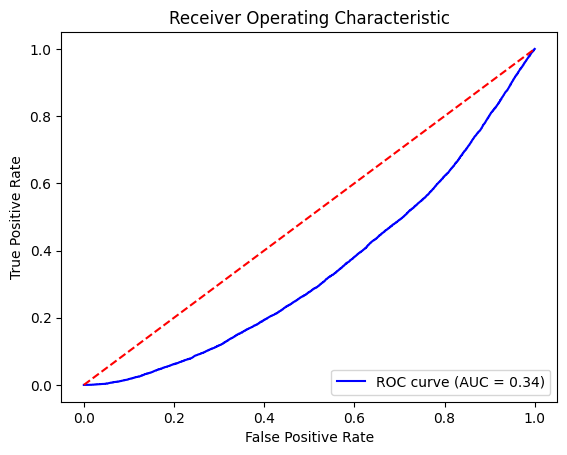

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_pred=model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


449/449 [==============================] - 1s 2ms/step


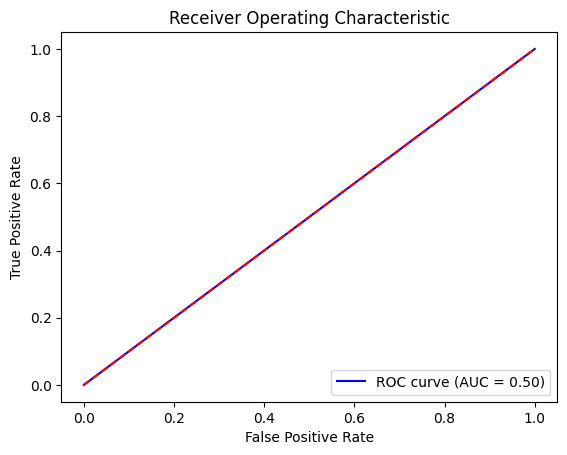

In [18]:
from sklearn.metrics import roc_curve, auc
y_pred=model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:

# Crea el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(bin_size, 4)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compila el modelo
model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy','MeanSquaredError','AUC'])

# Entrena el modelo
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# Evalúa el modelo en el conjunto de prueba
loss, accuracy, MSE, AUC = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

TypeError: ignored

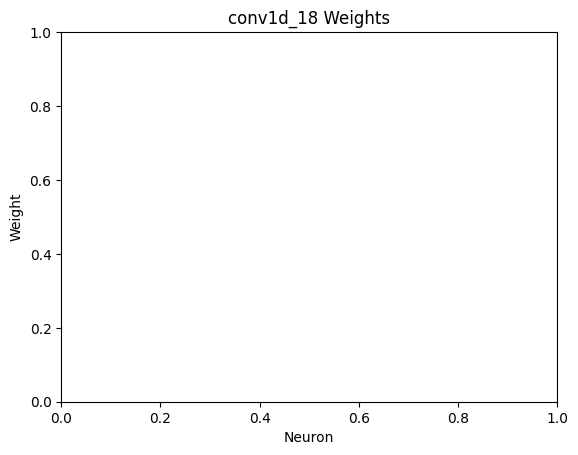

In [25]:
import matplotlib.pyplot as plt

# Obtén la lista de capas del modelo
layers = model.layers

# Itera sobre todas las capas y visualiza los pesos
for layer in layers:
    weights = layer.get_weights()
    if weights:  # Verifica si la capa tiene pesos
        layer_name = layer.name
        plt.figure()
        plt.title(layer_name + ' Weights')
        plt.xlabel('Neuron')
        plt.ylabel('Weight')
        plt.imshow(weights[0], cmap='coolwarm', aspect='auto')
        plt.colorbar()
        plt.show()


1070/1070 [==============================] - 3s 2ms/step


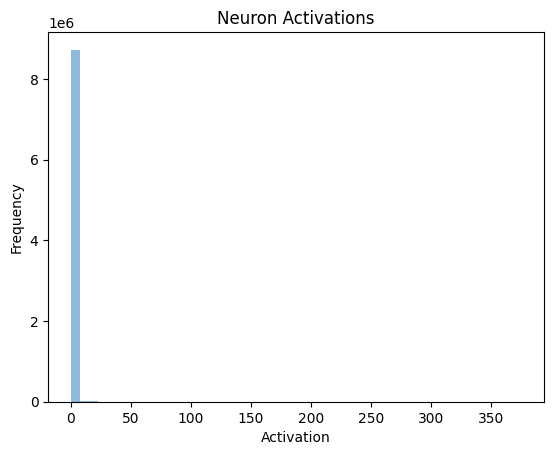

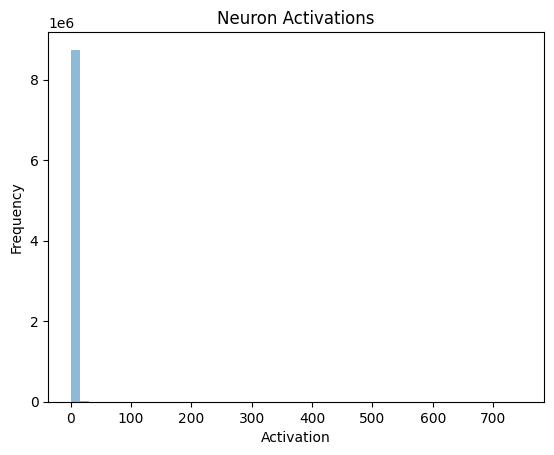

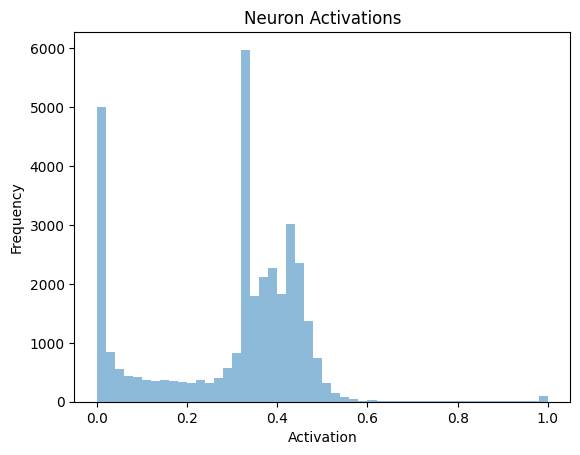

In [26]:
import matplotlib.pyplot as plt

# Obtén las activaciones de las capas ocultas
layer_outputs = [layer.output for layer in model.layers if 'dense' in layer.name]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_test)

# Genera los histogramas de las activaciones de las neuronas
for layer_activation in activations:
    num_neurons = layer_activation.shape[1]
    plt.figure()
    plt.title('Neuron Activations')
    plt.xlabel('Activation')
    plt.ylabel('Frequency')
    plt.hist(layer_activation.flatten(), bins=50, alpha=0.5)
    plt.show()


1/1 [==============================] - 0s 249ms/step


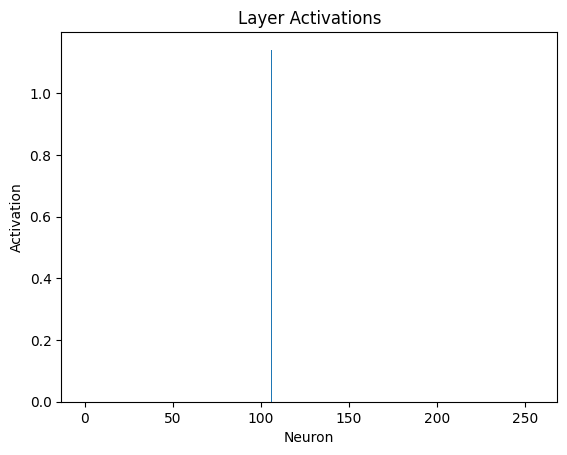

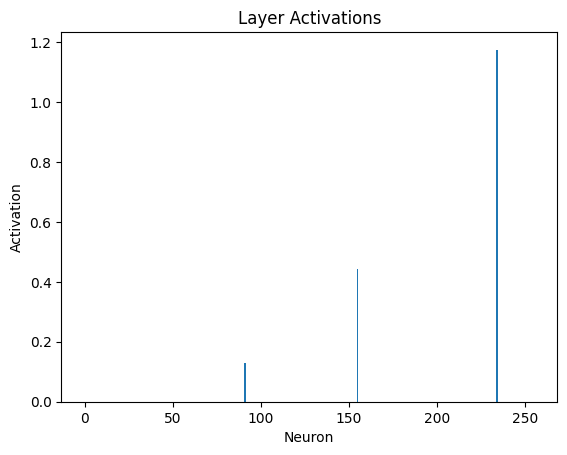

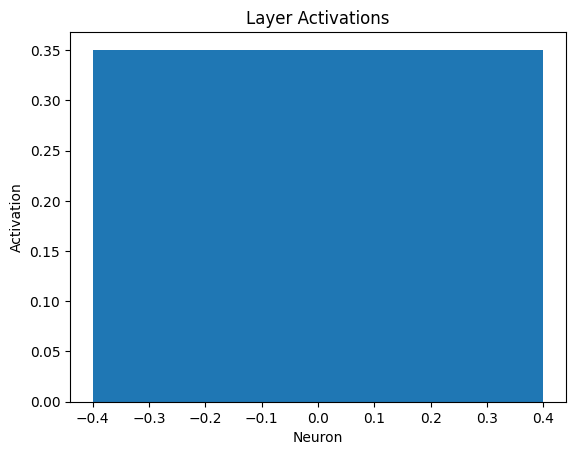

In [27]:
import tensorflow.keras.backend as K

# Crea un nuevo modelo que devuelve las salidas de las capas ocultas
layer_outputs = [layer.output for layer in model.layers if 'dense' in layer.name]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Obtén las salidas intermedias para una muestra de datos
sample_index = 0  # Índice de la muestra de datos a analizar
activations = activation_model.predict(X_test[sample_index:sample_index+1])

# Visualiza las salidas intermedias de las capas ocultas
for layer_activation in activations:
    num_neurons = layer_activation.shape[1]
    plt.figure()
    plt.title('Layer Activations')
    plt.xlabel('Neuron')
    plt.ylabel('Activation')
    plt.bar(range(num_neurons), layer_activation.flatten())
    plt.show()